In [2]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

from os.path import join
import numpy as np
from h5py import File
import matplotlib.pyplot as plt
import candel

%load_ext autoreload
%autoreload 2

In [3]:
mock_dir = "/Users/rstiskalek/Projects/CANDEL/data/CF4_mock"
CF4 = candel.pvdata.load_CF4_data("/Users/rstiskalek/Projects/CANDEL/data/CF4", which_band="w1")

2025-05-10 13:10:43 initially loaded 9788 galaxies from CF4 TFR data.
2025-05-10 13:10:43 removed 6537 galaxies, thus 3251 remain.


In [39]:
from jax import numpy as jnp

distmod2dist(jnp.asarray([40]))

Array([781.8412], dtype=float32)

In [4]:
distmod2dist = candel.Distmod2Distance()
distmod2redshift = candel.Distmod2Redshift()
log_grad_distmod2dist = candel.LogGrad_Distmod2ComovingDistance()

field_loader = candel.field.name2field_loader("Carrick2015")(
    path_density="/Users/rstiskalek/Projects/CANDEL/data/fields/carrick2015_twompp_density.npy",
    path_velocity="/Users/rstiskalek/Projects/CANDEL/data/fields/carrick2015_twompp_velocity.npy"
    )

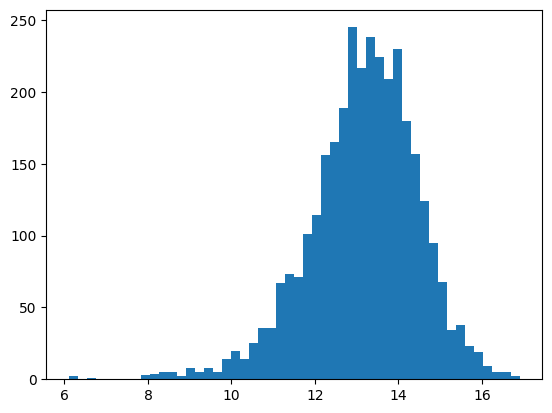

In [5]:
plt.figure()
plt.hist(CF4["mag"], bins="auto")
plt.show()

In [ ]:
kwargs = {
    'Vext_mag': 250,
    'Vext_ell': 300,
    'Vext_b': -5,
    'sigma_v': 150,
    'a_TFR': -19.62,
    'b_TFR': -9.5,
    'c_TFR': 9.5,
    'sigma_TFR': 0.28,
    'alpha': 0.,
    'beta': 0.,
    'h': 1,
    'mag': CF4['mag'] - 0.05,
    'eta': CF4['eta'],
    'mag_min': 7.5,
    'mag_max': 16.5,
    'e_mag': 0.05,
    'eta_mean': 0.0,
    'eta_std': 0.125,
    'e_eta': 0.023,
    'b_min': 7.5,
    'zcmb_max': 0.05,
    'r_h_max': 500,
    'distmod2dist': distmod2dist,
    'distmod2redshift': distmod2redshift,
    'log_grad_distmod2dist': log_grad_distmod2dist,
    'field_loader': field_loader,
    'use_data_prior': True,
    'rmin_reconstruction': 0.1,
    'rmax_reconstruction': 250,
    'num_steps_reconstruction':501,
}


In [67]:
nsamples = 251
fname = join(mock_dir, "mock_0.hdf5")

mock = candel.mock.gen_CF4_TFR_mock(nsamples, seed=30, **kwargs)

2025-05-10 16:19:37 interpolating the density field...
2025-05-10 16:19:37 interpolating the velocity field...


<string>:34: RuntimeWarning: invalid value encountered in log


2025-05-10 16:19:38 interpolating the density field...
2025-05-10 16:19:38 interpolating the velocity field...
2025-05-10 16:19:38 Rejecting 0 samples with zcmb > 0.05


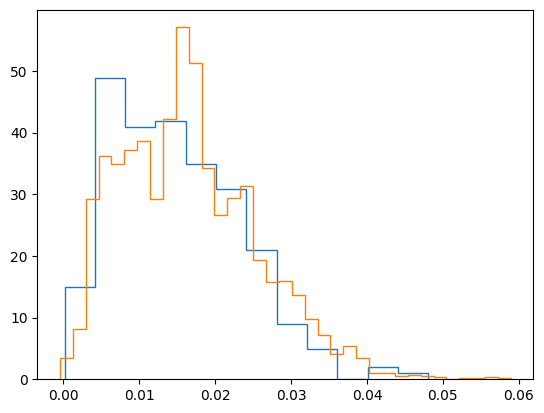

In [68]:
plt.figure()
plt.hist(mock["zcmb"], bins="auto", density=1, histtype="step", label="mock")
plt.hist(CF4["zcmb"], bins="auto", density=1, histtype="step", label="CF4")
plt.show()

In [69]:
print(f"writing `{fname}`.")
with File(fname, 'w') as f:
    grp = f.create_group("mock")
    for key, value in mock.items():
        grp.create_dataset(key, data=value, dtype=np.float32)

    for key, value in kwargs.items():
        if isinstance(value, (float, int, bool)):
            grp.attrs[key] = value


writing `/Users/rstiskalek/Projects/CANDEL/data/CF4_mock/mock_0.hdf5`.
